## 4. Modeling -- Binary Class Prediction on Text Political Lean

In [37]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV, validation_curve
import matplotlib.pyplot as plt


### TF-IDF Vectorizer

In [38]:
# Load training data
file_path_train_lean = "data/processed-data/train_lean.csv"
train_data = pd.read_csv(file_path_train_lean)
train_data = train_data.dropna(subset=['Text', 'Political Lean'])  # Drop rows with NaN in targetted columns

# Select features and target
X_train_text = train_data['Text']
y_train = train_data['Political Lean']

# Text vectorization (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')  
X_train = tfidf_vectorizer.fit_transform(X_train_text)

### Cross Validation

In [39]:
# Define hyperparameter grid for Decision Tree
param_grid = {
    'max_depth': [10, 15, 20, 25, 30, 50, None],  # Adjust depth of the tree
    'min_samples_split': [2, 5, 10, 20, 50],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 5, 10, 20],  # Minimum samples required at a leaf node
    'criterion': ['gini', 'entropy']  # Criterion for splitting
}

# Initialize Decision Tree classifier
clf = DecisionTreeClassifier(random_state=5000)

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Output best parameters from GridSearchCV
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Perform cross-validation on the best estimator found by GridSearchCV
cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring='accuracy')

print("Cross Validation Results:")
print(f"Accuracy Scores: {cv_scores}")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Train the best model on the full training set
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

Best parameters found:  {'criterion': 'gini', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation score: 0.6540
Cross Validation Results:
Accuracy Scores: [0.63580247 0.65843621 0.64197531 0.65979381 0.6742268 ]
Mean Accuracy: 0.6540
Standard Deviation: 0.0137


DecisionTreeClassifier(max_depth=15, random_state=5000)

### Visualization and Evaluation

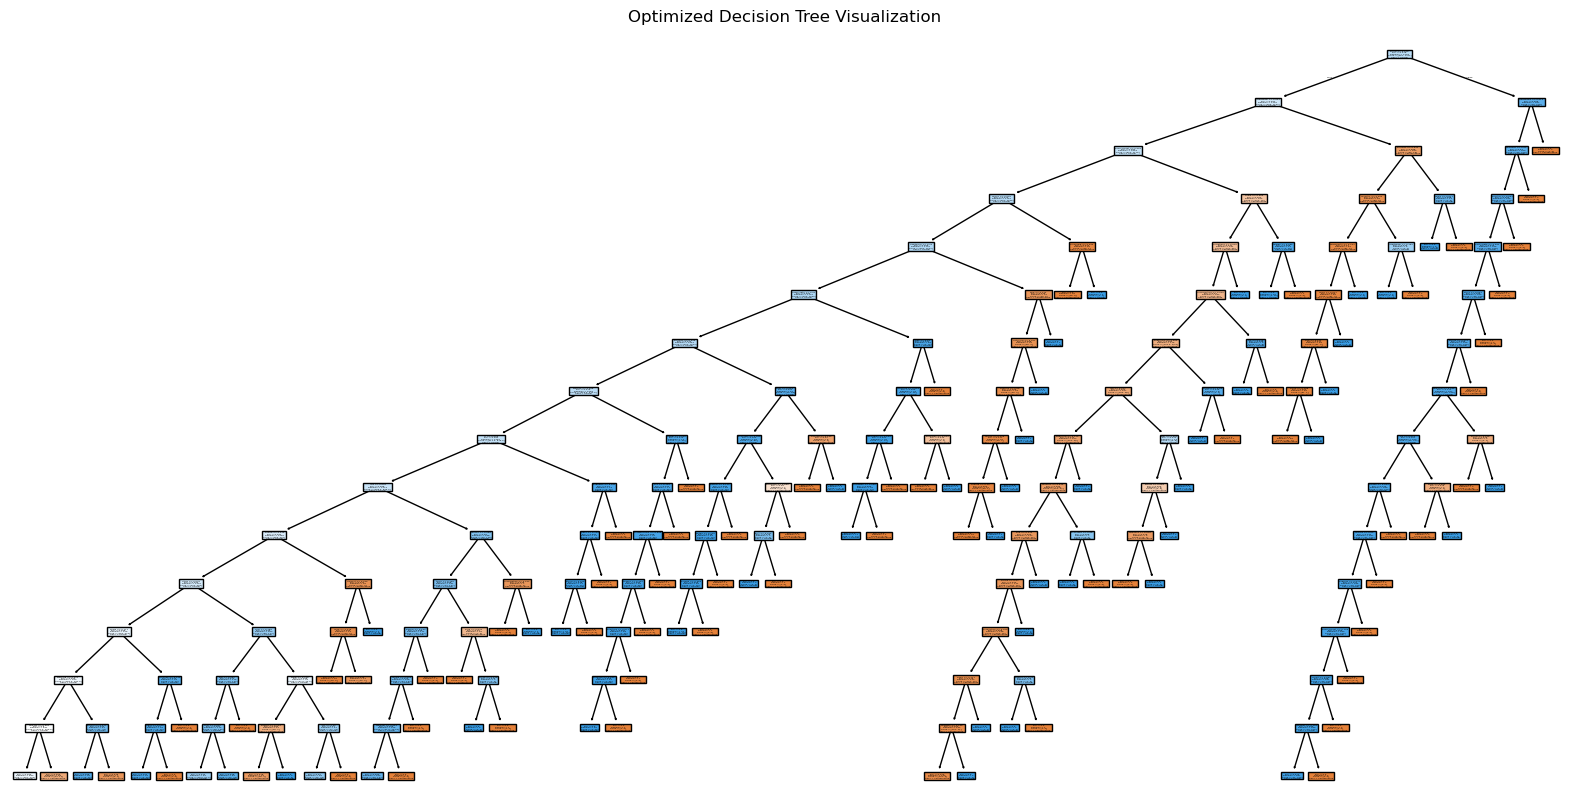

Training Set Evaluation:
              precision    recall  f1-score   support

Conservative       0.94      0.48      0.63       957
     Liberal       0.74      0.98      0.84      1471

    accuracy                           0.78      2428
   macro avg       0.84      0.73      0.74      2428
weighted avg       0.82      0.78      0.76      2428

Training Accuracy: 0.7821252059308073


In [40]:
# Visualize the trained decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_clf, feature_names=tfidf_vectorizer.get_feature_names_out(), class_names=best_clf.classes_, filled=True)
plt.title("Optimized Decision Tree Visualization")
plt.show()

# Model evaluation (on training data)
y_train_pred = best_clf.predict(X_train)
print("Training Set Evaluation:")
print(classification_report(y_train, y_train_pred))
print("Training Accuracy:", accuracy_score(y_train, y_train_pred))


### Prediction

In [41]:
# Load test data
file_path_text_topic = "data/processed-data/text_topic.csv"
test_data = pd.read_csv(file_path_text_topic)
test_data = test_data.dropna(subset=['text'])

# Use the same vectorizer
X_test_text = test_data['text']
X_test = tfidf_vectorizer.transform(X_test_text)

# Predict on test data
predictions = best_clf.predict(X_test)

# Add predictions to the test set
test_data['dt_lean'] = predictions

# Save predictions
file_path_text_lean = "data/processed-data/text_lean.csv"
df_text_lean = test_data
df_text_lean.to_csv(file_path_text_lean, index=False)

print(f"Modeling complete. Results saved to {file_path_text_lean}")
df_text_lean.head(6)

Modeling complete. Results saved to data/processed-data/text_lean.csv


,subreddit,id,type,depth,score,time,text,nmf_topic,dt_lean
0,Libertarian,1hf706u,submission_hot,0,100,2024/12,road serfdom new libertarian economic let borr...,abortion,Conservative
1,Libertarian,m29svuv,comment,1,1,2024/12,fredrich bastiat also good actually make funct...,abortion,Liberal
2,Libertarian,m2a5co6,comment,2,1,2024/12,libertarian exclusively anarchist,abortion,Conservative
3,Libertarian,m2a694w,comment,3,1,2024/12,true socialist communist always say fix ideolo...,abortion,Conservative
4,Libertarian,m29bopi,comment,1,7,2024/12,good favorite always recommend start revolutio...,abortion,Liberal
5,Libertarian,m2a1cm0,comment,1,1,2024/12,salma write book become movie star,abortion,Liberal
